In [31]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [32]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import random
import statnlpbook.util as util
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
import random 
from collections import defaultdict
random.seed(2)

In [33]:
%%HTML
<style>
td,th {
    font-size: x-large;
    text-align: left;
}
</style>

# Text Classification 

Automatically classify input text into a set of **atomic (discrete) classes**

## Motivation
* **Information retrieval**: classify documents into topics, such as "sport" or "business"
* **Sentiment analysis**: classify tweets into being "positive" or "negative"  
* **Spam filters**: distinguish between "ham" and "spam"

<!-- TODO: Load Web Corpus, 4 Universities, something were Maxent works -->

## Text Classification: Formal Definition

* Input space $\Xs$ are strings or sequences of tokens
* output space $\Ys$ is a set of labels
    * Example for document classification: $\Ys=\{ \text{sports},\text{business}\}$ 
    * Example for sentiment prediction: $\Ys=\{ \text{positive},\text{negative}, \text{neutral}\}$ 
* model $s_{\params}(\x,y)$ 
    * scores $y$ highly if it fits text $\x$
    

## This Lecture

* **Discriminative** model: *Logistic Regression*
    * Learn how to *discriminate best output based on input*: $\prob(y|\x) \propto s_{\params}(\x,y)$

## Discriminative Text Classification

How can we estimate probabilities algorithmically?

Frame the task as an optimisation problem and

maximise $\prob_\params(+ \bar \text{...Pulp Fiction...})$

### Negative Log-Likelihood (NLL) Loss

Maximise the likelihood of the correct labels (given the input), or equivalently,

**Minimise** the **negative log-likelihood** of the correct labels

$$
\mathcal{L}(\params) = -\sum_{(\x,y) \in \train} \log\left(\prob(y|\x)\right)
$$

### Log-Linear Models

Model the score as

$$
s_\theta(y_i, \x) = \frac{\exp(\weights_i f(\x, y_i))}{\sum_{j=1}^C \exp(\weights_j f(\x, y_j))}
$$

This is also often called **softmax**.

### Feature Function

For log-linear models we need **feature functions** $f_i(\x, y)$ mapping input to a real value.

For simplicity $f_i(\x, y)$ depends only on $\x$, e.g.,

$$
f_{\text{Pulp}}(\x) = \counts{\x}{\text{Pulp}}
$$
i.e., the number of times *Pulp* appears in the input $\x$.  

In [37]:
p,f = "Pulp", "Fiction"
data = [((p,f),True),((p,f),True),((p,f),True), ((f,),False), ((f,),False),((p,f),False)]
data

[(('Pulp', 'Fiction'), True),
 (('Pulp', 'Fiction'), True),
 (('Pulp', 'Fiction'), True),
 (('Fiction',), False),
 (('Fiction',), False),
 (('Pulp', 'Fiction'), False)]

In [38]:
from math import log, exp

def nll(data, w_p_true, w_f_true, w_true, l=0.0):
    loss = 0.0
    for x,y in data:
        count_p = len([w for w in x if w==p])
        count_f = len([w for w in x if w==f])
        score_true = w_true + count_p * w_p_true + count_f * w_f_true
        log_z = log(exp(score_true) + exp(0))
        if y:
            loss += score_true - log_z
        else:
            loss += -log_z
    return l * (w_p_true * w_p_true + w_f_true * w_f_true + w_true * w_true) - loss

import matplotlib.pyplot as plt
import numpy as np


## Minimising the Negative Log-Likelihood
No closed form solution

Use **iterative methods** such as (Stochastic) Gradient Descent (SGD)

"Easy" because the loss is a **convex** function of the weights $\weights$

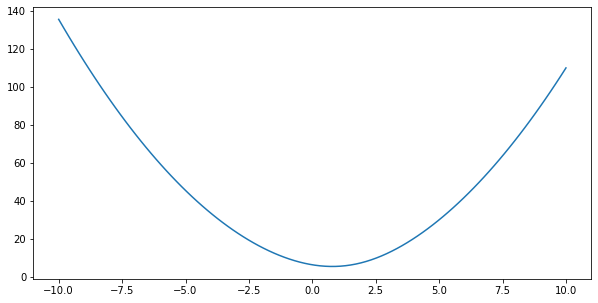

In [39]:
x = np.linspace(-10, 10, 100)
C = 1
nll_loss = np.vectorize(lambda w: nll(data,w,log(0.5),log(0.5),1/C))
plt.plot(x, nll_loss(x))

### How to Find the Minimum?

In practice one of the following:
* Implement both optimisation and gradient calculation
* Use off-the-shelf optimisation library (such as scipy) and implement the gradient calculation
* Use a library that calculates gradients automatically (such as PyTorch or Tensorflow)
* Use a library that implements specific models (such as [scikit-learn](http://scikit-learn.org/))


## Regularisation
Estimating a log-linear models can lead to *overfitting*

* For example, reviews of movies often contain the **name** of the movie
* False *killer feature*: only appears in one training instance
* Weight can be set in way that we get perfect accuracy on this instance

*Regularise* the model by **penalising** large weights:

* Add a regularisation penalty to the training objective
* For example, the L2 or L1 norm of the weight vector (ridge/lasso regularisation)


$$
||\params||_1 = \left(\sum_{i=1}^N |w_i|\right)
$$
$$
||\params||_2 = \sqrt{\sum_{i=1}^N w_i^2}
$$

The hyperparameter $\alpha$ controls strength of regularisation:

$$
\mathcal{L}^1_\alpha(\params) = \mathcal{L}(\params) + \alpha ||\params||_1
$$
$$
\mathcal{L}^2_\alpha(\params) = \mathcal{L}(\params) + \alpha ||\params||_2
$$

Both L1 and L2 have their strength and weaknesses. 
* L1 regularisation can lead to sparse vectors with mostly zero weights
* L2 (also called "weight decay" in PyTorch) is more common in modern NLP

## Logistic Regression Toolkits
A log-linear model trained by minimising the NLL corresponds to training a **logistic regression** model (or equivalently, a one-layer neural network)

The [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model is implemented in [scikit-learn](http://scikit-learn.org/stable/index.html). Let's use it to implement a simple classifier:

## Sentiment Analysis as Text Classification
Let us focus on a specific task: sentiment analysis

* load data for this task from the [Movie Review dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/)

In [34]:
from os import listdir
from os.path import isfile, join
def load_from_dir(directory,label):
    """
    Load documents from a directory, and give them all the same label `label`.
    Params:
        directory: the directory to load the documents from.
        label: the label to assign to each document.
    Returns:
        a list of (x,y) pairs where x is a tokenised document (list of words), and y is the label `label`.
    """
    result = []
    for file in listdir(directory):
        with open(directory + file, 'r') as f:
            text = f.read()
            tokens = [t.strip() for t in text.split()]
            result.append((tokens,label))
    return result
 
data_pos = load_from_dir('../data/rt-2k/txt_sentoken/pos/', 'pos') 
data_neg = load_from_dir('../data/rt-2k/txt_sentoken/neg/', 'neg')
    
data_all = data_pos + data_neg

Let us look at some example data ...

In [35]:
" ".join(data_pos[12][0][:200])

"look back at all the times in your life when there was a fork in the path to the future . some sort of decision had to be made , and , for better or worse , it irrevocably altered the course of your existence . >from time-to-time , everyone thinks about the roads not taken , and how things might have turned out if the choice had been different . perhaps even more dizzying to contemplate is how a seemingly minor action -- catching the 10 am train , for example -- could have an equally profound , yet less obvious , impact . maybe that's where you met your significant other , and , had you reached the platform just a few seconds later ? film makers are no less fascinated by issues of destiny than anyone else , and that's why there's no shortage of movies about this subject . the best of the bunch were probably made by the late polish director krzysztof kieslowski , who was obsessed with questions of fate and chance . these themes weave their way through many of his movies , including dec

## Setup

Divide dataset in **train**, **test** and **development** set

In [36]:
random.seed(0)
shuffled = list(data_all)
random.shuffle(shuffled)
train, dev, test = shuffled[:1600], shuffled[1600:1800], shuffled[1800:]
len([(x,y) for (x,y) in train if y == 'pos']) # check balance 

815

Convert $\x \in \Xs$ to a (sparse) feature vector $\mathbf{f}(\x)$:

In [40]:
from collections import Counter

def feats(x):
    return Counter(x)

feats(['pulp','fiction','fiction'])

Counter({'pulp': 1, 'fiction': 2})

Apply to training and validation instances:

In [41]:
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()

train_X = vectorizer.fit_transform([feats(x) for x,_ in train])
dev_X = vectorizer.transform([feats(x) for x,_ in dev])
dev_X

<200x45760 sparse matrix of type '<class 'numpy.float64'>'
	with 65513 stored elements in Compressed Sparse Row format>

scikit-learn prefers numbers as classes:

* $\text{positive}\rightarrow 0$
* $\text{negative}\rightarrow 1$

In [42]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_Y = label_encoder.fit_transform([y for _,y in train])
dev_Y = label_encoder.transform([y for _,y in dev])

dev_Y[:10] 

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1])

Train the logistic regression with L1 regularisation with $\frac{1}{\alpha}=C=1000$

In [43]:
from sklearn.linear_model import LogisticRegression
import numpy as np

lr = LogisticRegression(C=1000, penalty="l1", random_state=1, solver='liblinear')
lr.fit(train_X, train_Y)

LogisticRegression(C=1000, penalty='l1', random_state=1, solver='liblinear')

Weights learned:
* single weight vector $\weights=\weights_\text{positive} - \weights_\text{negative}$

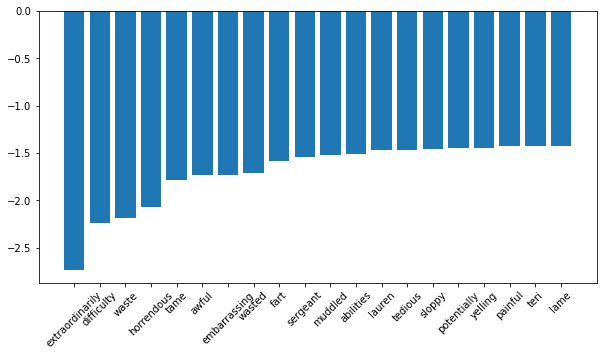

In [44]:
weights = vectorizer.inverse_transform(lr.coef_)[0]
sorted_weights = sorted(weights.items(), key=lambda t: t[1])
util.plot_bar_graph([w for _,w in sorted_weights[:20]],
                    [f for f,_ in sorted_weights[:20]],rotation=45)

More obvious **discriminative** features for the negative class 

* Conditional log-likelihood down-weighs a feature $f_i$ for $y=-$ 
    * if $f_i$ is active in $\x$
    * but gold label is $y=+$



Positive weights? 

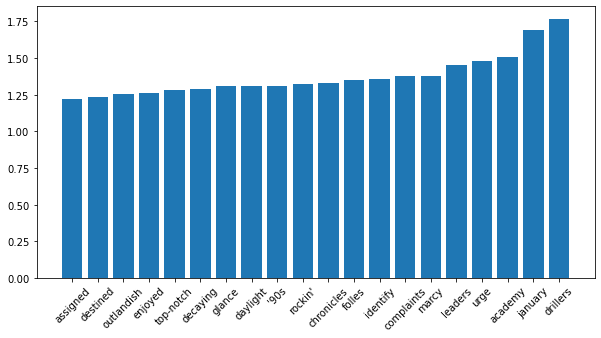

In [45]:
util.plot_bar_graph([w for _,w in sorted_weights[-20:]],
                    [f for f,_ in sorted_weights[-20:]],rotation=45)

## Evaluation

How can we quantify how well our models do?

Use **accuracy**, the ratio of the 

* number of correct predictions and the 
* number of all predictions  

$\hat{\y}$ is predicted sequence of labels, $\y$ the true labels:

$$
\mathrm{Acc}(y_1,\ldots,y_n, \hat{y}_1,\ldots,\hat{y}_n) = \frac{\sum_i \indi [ y_i = \hat{y}_i]}{n}
$$

In [ ]:
def accuracy(gold, guess):
    correct = 0
    for y_gold,y_guess in zip(gold,guess):
        if y_guess == y_gold:
            correct += 1
    return correct / len(gold)

train_Y_lex = [y for _,y in train]
dev_Y_lex = [y for _,y in dev]

In [ ]:
lr = LogisticRegression(C=1000, penalty="l2",random_state=1, tol=0.00001, solver='liblinear')
lr.fit(train_X, train_Y)
lr_guess = label_encoder.inverse_transform(lr.predict(dev_X))
accuracy(dev_Y_lex, lr_guess)

## More on Feature Functions

Reminder: For log-linear models we need **feature functions** $f_i(\x)$ mapping input to a real value, e.g.

$$
f_{\text{Pulp}}(\x) = \counts{\x}{\text{Pulp}}
$$
i.e., the number of times *Pulp* appears in the input $\x$.  

How to get a better feature function?

### Stop Words

Non-content words

In [ ]:
import string

stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', '\n', 'the'] + list(string.punctuation))

Shouldn't the model learn to ignored those since they are distributed similarly across classes? 

Let's see what weights our model learned for non-content words

In [ ]:
stopword_weights = [(w, weight) for w, weight in sorted_weights if w in stop_words]

# Highest negative stopword weights
util.plot_bar_graph([w for _,w in stopword_weights[:20]],
                    [f for f,_ in stopword_weights[:20]],rotation=45)

In [ ]:
# Highest positive stopword weights
util.plot_bar_graph([w for _,w in stopword_weights[-20:]],
                    [f for f,_ in stopword_weights[-20:]],rotation=45)

Why does this happen?

Discuss and enter your answer(s) here: https://ucph.page.link/nlp_q3

([Responses](https://docs.google.com/forms/d/1bXldAjGhvyycpN4k8zEccxS0PezgIgZjTMICVgJaR_E/edit#responses))

Let's remove stopwords from the data and re-train our model

In [ ]:
def filter_dataset(data):
    """
    Removes stop words from a dataset of (x,y) pairs.
    """
    return [([w for w in x if w not in stop_words],y) for x,y in data]

train_filtered = filter_dataset(train)
dev_filtered = filter_dataset(dev)
test_filtered = filter_dataset(test)

train_X_filtered = vectorizer.fit_transform([feats(x) for x,_ in train_filtered])
dev_X_filtered = vectorizer.transform([feats(x) for x,_ in dev_filtered])
dev_X_filtered

In [ ]:
lr = LogisticRegression(C=1000, penalty="l2",random_state=1, tol=0.00001, solver='liblinear')
lr.fit(train_X_filtered, train_Y)
lr_guess = label_encoder.inverse_transform(lr.predict(dev_X_filtered))
accuracy(dev_Y_lex, lr_guess)

## Bigram Representation

Features don't have to correspond to single words
$$
f_{\text{Pulp Fiction}}(\x) = \counts{\x}{\text{Pulp Fiction}}
$$

Use a **bag of bigrams**

* Count bigrams (like Pulp Fiction) and not just single words

features don't even have to correspond to n-grams
$$
f_{\text{RT}}(\x) = \text{Lowest rotten tomatoes score of all mentioned movies in }\x
$$

## Summary

* Text classification can be framed as **discriminative** learning problem
    * Learn how to *discriminate best output based on input*
    * Increase relative/conditional probability of classes
* Ingredients
    * Model (commonly used: logistic regression)
    * Feature function
    * Regularisation
* Evaluation
    * Quantitative evaluation: measure accuracy
    * Qualitative evaluation: inspect feature weights

### Preview: Next Two Lectures

* More on the feature function
* *Learn* features as opposed to manually defining them (**representation learning**)
    * Benefit: often better performance, less feature engineering
    * Downside: black box models -- harder to inspect model and interpret feature weights
    * De-facto approach to NLP currently
    * Very popular active research topic -- basics here, more in Advanced Topics in NLP course

## Background Material
* Longer version of lecture on text classification: [notes](chapters/doc_classify.ipynb), [slides](chapters/doc_classify_slides.ipynb)
* [Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://www.aclweb.org/anthology/P12-2018), Sida Wang and Christopher D. Manning, ACL 2012 
* [Thumbs up? Sentiment Classification using Machine Learning
Techniques](http://www.cs.cornell.edu/home/llee/papers/sentiment.pdf), Bo Pang, Lillian Lee and Shivakumar Vaithyanathan, EMNLP 2002
* Jurafsky & Martin, [Speech and Language Processing (Third Edition)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf): Chapter 4, Naive Bayes and Sentiment Classification + Chapter 5, Logistic Regression